# Multiclass Classification of Fatal Car Crashes
Authors:  Ned Kost, Ulises Gomez
Date:  August 25th, 2023

## Goal
Predict the contributing factor for a fatal car crash.  The contributing factor will fall into 3 categories: 
- drunk_driver_involved
- speeding_driver_involved
- other

## TODO
- Load Data into dataframe and clean it
- Identify features to use for the classifier model
- Find a classifier that will do multiclass and probabilty as output.  Preferrably with explainability
- Dockerize the output

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.svm import SVC

import xgboost as xgb

from sklearn.preprocessing import LabelEncoder

In [2]:
warnings.filterwarnings("ignore")

## Load and Clean Data

In [8]:
from pathlib import Path
import pandas as pd

In [9]:
train_directory = Path("../data/fars_train.csv")
test_directory = Path("../data/fars_test.csv")

In [10]:
# Load data from Dataframe
df = pd.read_csv(train_directory, quoting=1, delimiter=',')
df.head()

,u_id,fatals,a_ct,a_ped_f,a_pedal_f,a_roll,a_hr,a_polpur,month,day,...,owner,deaths,numoccs,impact1,deformed,ve_forms,ve_total,weather,lgt_cond,driver_factor
0,32083,1,Single-Vehicle Crash,Other Crash,Other Crash,Other Crash,No - Hit and Run,Other Crash,10,2,...,Driver (in this crash) Was Registered Owner,1,1.0,Clockpoint 12,Disabling damage,1,1,Clear,Dark - not lighted,other
1,55073,1,Single-Vehicle Crash,Other Crash,Other Crash,Other Crash,No - Hit and Run,Other Crash,6,21,...,Driver (in this crash) Not Registered Owner (o...,1,1.0,Clockpoint 1,Disabling damage,1,1,Clear,Daylight,speeding_driver_involved
2,7458,1,Single-Vehicle Crash,Other Crash,Other Crash,Other Crash,No - Hit and Run,Other Crash,7,14,...,Driver (in this crash) Was Registered Owner,0,1.0,Clockpoint 12,NaN,1,1,Clear,Daylight,other
3,5685,1,Single-Vehicle Crash,Other Crash,Other Crash,Other Crash,No - Hit and Run,Other Crash,9,15,...,Driver (in this crash) Not Registered Owner (o...,0,1.0,Clockpoint 12,Functional damage,1,1,Clear,Dark - not lighted,other
4,9245,1,Single-Vehicle Crash,Other Crash,Other Crash,Other Crash,No - Hit and Run,Other Crash,9,28,...,Driver (in this crash) Was Registered Owner,1,1.0,Clockpoint 9,Disabling damage,1,1,Clear,Dark - not lighted,drunk_driver_involved


In [13]:
def binary_cat(row_value, zero_value):
    return 0 if row_value == zero_value else 1

In [14]:
#Clean up Categorical Data
features = ['fatals', 'age', 'permvit', 'deaths', 'month', 'pernotmvit', 've_total']

cleaned_df = df[features]
#cleaned_df['numoccs'] = cleaned_df['numoccs'].fillna(0.0)

#Create columns for Binary Features
cleaned_df['is_ped_fatality'] = df['a_ped_f'].apply(lambda x: binary_cat(x, 'Other Crash'))
cleaned_df['is_weekend'] = df['a_dow_type'].apply(lambda x: binary_cat(x, 'Weekday'))
cleaned_df['is_night'] = df['a_tod_type'].apply(lambda x: binary_cat(x, 'Daytime'))
cleaned_df['is_urban'] = df['a_ru'].apply(lambda x: binary_cat(x, 'Rural'))
cleaned_df['is_inter'] = df['a_inter'].apply(lambda x: binary_cat(x, 'Non-Interstate'))
cleaned_df['is_intsec'] = df['a_intsec'].apply(lambda x: binary_cat(x, 'Non-Intersection'))
cleaned_df['on_roadway'] = df['a_relrd'].apply(lambda x: 1 if x.startswith('On') else 0)
cleaned_df['off_roadway'] = df['a_relrd'].apply(lambda x: 1 if x.startswith('Off') else 0)
cleaned_df['is_junc'] = df['a_junc'].apply(lambda x: 1 if str(x).startswith('Junct') else 0)
cleaned_df['not_junc'] = df['a_junc'].apply(lambda x: 1 if str(x).startswith('Non') else 0)
cleaned_df['is_bike_fatality'] = df['a_ped_f'].apply(lambda x: binary_cat(x, 'Other Crash'))
#cleaned_df['is_rollover'] = df['a_roll'].apply(lambda x: binary_cat(x, 'Other Crash'))   #hurt multi-nomial output
cleaned_df['is_hit_and_run'] = df['a_hr'].apply(lambda x: binary_cat(x, 'No - Hit and Run'))  #no impact to multi-nomial
cleaned_df['is_police_pursuit'] = df['a_polpur'].apply(lambda x: binary_cat(x, 'Other Crash'))  
cleaned_df['is_ped'] = df['a_ped'].apply(lambda x: binary_cat(x, 'no'))  


#Create columns for non-Ordinal Features
label_encoder = LabelEncoder()     #Create Label Encoder
cleaned_df['body_type'] = label_encoder.fit_transform(df['a_body'])
cleaned_df['owner_reg'] = label_encoder.fit_transform(df['owner'])
cleaned_df['impact_loc'] = label_encoder.fit_transform(df['impact1'])
cleaned_df['weather_cond'] = label_encoder.fit_transform(df['weather'])
cleaned_df['light_cond'] = label_encoder.fit_transform(df['lgt_cond'])


#Create column for Ordinal Features (treating as non-ordinal FOR NOW)
cleaned_df['road_type'] = label_encoder.fit_transform(df['a_roadfc'])
cleaned_df['deform_type'] = label_encoder.fit_transform(df['deformed'])
#cleaned_df['state_occ'] = label_encoder.fit_transform(df['state'])  #very minor neg impat to multi-nomial



# Build Train and Test dataset

In [16]:
#Create Datasets to use in Models
X, y = cleaned_df, df["driver_factor"]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=125)

In [18]:
X_train.head()

,fatals,age,permvit,deaths,month,pernotmvit,ve_total,is_ped_fatality,is_weekend,is_night,...,is_hit_and_run,is_police_pursuit,is_ped,body_type,owner_reg,impact_loc,weather_cond,light_cond,road_type,deform_type
2542,1,55,1,0,10,1,1,1,1,1,...,0,0,1,0,1,15,2,0,3,1
43289,1,63,1,1,1,0,1,0,0,0,...,0,0,0,0,1,2,2,1,2,0
14110,1,53,1,1,12,0,1,0,1,0,...,0,0,0,4,1,4,3,4,4,0
40780,1,86,1,1,12,0,1,0,0,0,...,0,0,0,2,1,4,2,4,2,0
17451,2,33,2,2,7,0,4,0,1,1,...,0,0,0,0,1,4,2,0,4,0


In [19]:
y_train.head()

2542                     other
43289    drunk_driver_involved
14110    drunk_driver_involved
40780                    other
17451    drunk_driver_involved
Name: driver_factor, dtype: object

# Random Forest Model

In [22]:
X_train.head()

,fatals,age,permvit,deaths,month,pernotmvit,ve_total,is_ped_fatality,is_weekend,is_night,...,is_hit_and_run,is_police_pursuit,is_ped,body_type,owner_reg,impact_loc,weather_cond,light_cond,road_type,deform_type
2542,1,55,1,0,10,1,1,1,1,1,...,0,0,1,0,1,15,2,0,3,1
43289,1,63,1,1,1,0,1,0,0,0,...,0,0,0,0,1,2,2,1,2,0
14110,1,53,1,1,12,0,1,0,1,0,...,0,0,0,4,1,4,3,4,4,0
40780,1,86,1,1,12,0,1,0,0,0,...,0,0,0,2,1,4,2,4,2,0
17451,2,33,2,2,7,0,4,0,1,1,...,0,0,0,0,1,4,2,0,4,0


In [23]:
y_train.head()

2542                     other
43289    drunk_driver_involved
14110    drunk_driver_involved
40780                    other
17451    drunk_driver_involved
Name: driver_factor, dtype: object

In [67]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
print(rf_model)

RandomForestClassifier(random_state=42)


In [68]:
# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [69]:
# Predict on the test set
y_pred = rf_model.predict(X_test)

In [70]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Print classification report
class_report = classification_report(y_test, y_pred)
print('Classification Report:')
print(class_report)


Accuracy: 0.66
Classification Report:
                          precision    recall  f1-score   support

   drunk_driver_involved       0.55      0.60      0.57      3873
                   other       0.73      0.82      0.77      8614
speeding_driver_involved       0.41      0.18      0.25      2458

                accuracy                           0.66     14945
               macro avg       0.56      0.53      0.53     14945
            weighted avg       0.63      0.66      0.64     14945



In [77]:
importances = rf_model.feature_importances_
print(importances)

[0.00590692 0.18700151 0.04006918 0.03578693 0.11977213 0.02643646
 0.00869792 0.01331593 0.01900402 0.03402342 0.02449158 0.00679068
 0.00625597 0.01958292 0.02301623 0.00620965 0.01322538 0.01187508
 0.00479949 0.00503843 0.00878995 0.06246309 0.04488632 0.07623453
 0.04827175 0.05130029 0.06842898 0.02832527]


In [79]:
X.columns

Index(['fatals', 'age', 'permvit', 'deaths', 'month', 'pernotmvit', 've_total',
       'is_ped_fatality', 'is_weekend', 'is_night', 'is_urban', 'is_inter',
       'is_intsec', 'on_roadway', 'off_roadway', 'is_junc', 'not_junc',
       'is_bike_fatality', 'is_hit_and_run', 'is_police_pursuit', 'is_ped',
       'body_type', 'owner_reg', 'impact_loc', 'weather_cond', 'light_cond',
       'road_type', 'deform_type'],
      dtype='object')

In [85]:
def get_sorted_indices(lst):
    sorted_indices = sorted(range(len(lst)), key=lambda i: lst[i], reverse=True)
    return sorted_indices

# Example list of floating point values
sorted_indices = get_sorted_indices(importances)

print("Indices in order of largest to smallest values:", X.columns[sorted_indices])


Indices in order of largest to smallest values: Index(['age', 'month', 'impact_loc', 'road_type', 'body_type', 'light_cond',
       'weather_cond', 'owner_reg', 'permvit', 'deaths', 'is_night',
       'deform_type', 'pernotmvit', 'is_urban', 'off_roadway', 'on_roadway',
       'is_weekend', 'is_ped_fatality', 'not_junc', 'is_bike_fatality',
       'is_ped', 've_total', 'is_inter', 'is_intsec', 'is_junc', 'fatals',
       'is_police_pursuit', 'is_hit_and_run'],
      dtype='object')


In [78]:
len(importances)

28

# Support Vector Machine Model

In [34]:
# Initialize the SVM model
svm_model = SVC(kernel='linear', random_state=42)
print(svm_model)

SVC(kernel='linear', random_state=42)


In [35]:
# Train the model
svm_model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [36]:
# Predict on the test set
y_pred = svm_model.predict(X_test)

In [37]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Print classification report
class_report = classification_report(y_test, y_pred)
print('Classification Report:')
print(class_report)

Accuracy: 0.64
Classification Report:
                          precision    recall  f1-score   support

   drunk_driver_involved       0.48      0.71      0.57      3873
                   other       0.74      0.78      0.76      8614
speeding_driver_involved       0.50      0.03      0.06      2458

                accuracy                           0.64     14945
               macro avg       0.57      0.51      0.46     14945
            weighted avg       0.63      0.64      0.59     14945



# Gradient Boosting Model

In [21]:
# Initialize the label encoder
label_encoder = LabelEncoder()

In [22]:
# Fit and transform the target labels
y_train_encoded = label_encoder.fit_transform(y_train)

In [23]:
y_train_encoded

array([1, 0, 0, ..., 1, 0, 2])

In [24]:
# Fit and transform the target labels
y_test_encoded = label_encoder.fit_transform(y_test)

In [25]:
y_test_encoded

array([2, 1, 0, ..., 2, 0, 1])

In [61]:
from hyperopt import hp, fmin, tpe

# Define the hyperparameter search space
space = {
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'n_estimators': hp.quniform('n_estimators', 50, 300, 10),
    # Add more hyperparameters to tune
}

def objective(params):
    # Create and train XGBoost model
    model = xgb.XGBClassifier(
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        n_estimators=int(params['n_estimators']),
        # Initialize other hyperparameters
    )
    
    model.fit(X_train, y_train_encoded)
    
    # Calculate a metric to minimize (e.g., negative validation accuracy)
    val_accuracy = -model.score(X_test, y_test)
    
    return val_accuracy

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,  # Number of iterations
    # rstate=np.random.RandomState(42),  # Remove this line
)


print("Best hyperparameters:", best)


100%|██████████| 50/50 [02:22<00:00,  2.85s/trial, best loss: -0.0]
Best hyperparameters: {'learning_rate': 0.13465232824084064, 'max_depth': 6.0, 'n_estimators': 190.0}


In [41]:
# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(objective="multi:softmax", num_class=3, n_estimators=100, random_state=42)

In [34]:
xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softmax', predictor=None, ...)

In [42]:
# Train the model
xgb_model.fit(X_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_class=3,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [43]:
# Predict on the test set
y_pred = xgb_model.predict(X_test)

In [49]:
y_pred

array([0, 1, 0, ..., 0, 0, 1])

In [50]:
y_test

2570     speeding_driver_involved
11362                       other
505         drunk_driver_involved
8967        drunk_driver_involved
38683    speeding_driver_involved
                   ...           
8641                        other
15727    speeding_driver_involved
36799    speeding_driver_involved
28963       drunk_driver_involved
7481                        other
Name: driver_factor, Length: 14945, dtype: object

In [47]:
from sklearn.metrics import f1_score

# Convert numeric labels to strings in y_pred
y_pred_str = [str(label) for label in y_pred]

# Calculate macro F1 score using string labels
macro_f1 = f1_score(y_test, y_pred_str, average="macro")

In [48]:
macro_f1

0.0

In [54]:
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

# Convert string labels in y_test to numeric labels
label_encoder = LabelEncoder()
y_test_numeric = label_encoder.fit_transform(y_test)

# Calculate macro F1 score
macro_f1 = f1_score(y_test_numeric, y_pred, average="macro")


In [55]:
macro_f1

0.5588870565434837

In [45]:
# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Print classification report
class_report = classification_report(y_test_encoded, y_pred)
print('Classification Report:')
print(class_report)

Accuracy: 0.68
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.64      0.60      3873
           1       0.75      0.83      0.79      8614
           2       0.48      0.21      0.29      2458

    accuracy                           0.68     14945
   macro avg       0.60      0.56      0.56     14945
weighted avg       0.66      0.68      0.66     14945



In [31]:
def get_columns_by_feature_importance(model: RandomForestClassifier, X: pd.DataFrame) -> np.ndarray:
    """
    Get column names sorted by feature importance based on a RandomForestClassifier model.

    Parameters:
        model (RandomForestClassifier): The trained RandomForestClassifier model.
        X (pd.DataFrame): The input DataFrame containing features.

    Returns:
        np.ndarray: An array of column names sorted by feature importance.
    """
    importances = model.feature_importances_
    sorted_indices = sorted(range(len(importances)), key=lambda i: importances[i], reverse=True)

    return X.columns[sorted_indices]

In [32]:
get_columns_by_feature_importance(model=xgb_model, X=X)

Index(['deaths', 'is_night', 'off_roadway', 'is_police_pursuit',
       'is_hit_and_run', 'light_cond', 'is_weekend', 'age', 'is_inter',
       'road_type', 'is_ped', 'deform_type', 'body_type', 'weather_cond',
       'is_ped_fatality', 'owner_reg', 'permvit', 'impact_loc', 'not_junc',
       'is_urban', 'is_junc', 'on_roadway', 'fatals', 'is_intsec', 've_total',
       'month', 'pernotmvit', 'is_bike_fatality'],
      dtype='object')

# Neural Network Model

In [100]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report

In [101]:
# Convert target labels to numerical values
label_mapping = {'speeding_driver_involved': 0, 'drunk_driver_involved': 1, 'other': 2}
y = y.map(label_mapping)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=125)

In [102]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [103]:
# Convert target labels to categorical format
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [104]:
# Build the neural network model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [124]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

# Build a deeper neural network with BatchNormalization and dropout
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(BatchNormalization())  # Adding BatchNormalization layer
model.add(Dropout(0.5))  # Adding dropout layer
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())  # Adding BatchNormalization layer
model.add(Dropout(0.5))  # Adding dropout layer
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())  # Adding BatchNormalization layer
model.add(Dropout(0.5))  # Adding dropout layer
model.add(Dense(3, activation='softmax'))

# Compile the model with adjusted learning rate and optimizer
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Add learning rate scheduling
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model with more epochs and batch size
history = model.fit(X_train_scaled, y_train_categorical, epochs=100, batch_size=64,
                    validation_split=0.2, callbacks=[lr_scheduler], verbose=1)


Epoch 1/100
380/380 [==============================] - 2s 3ms/step - loss: 1.0729 - accuracy: 0.5514 - val_loss: 0.7797 - val_accuracy: 0.6677 - lr: 0.0010
Epoch 2/100
380/380 [==============================] - 1s 3ms/step - loss: 0.8421 - accuracy: 0.6293 - val_loss: 0.7716 - val_accuracy: 0.6680 - lr: 0.0010
Epoch 3/100
380/380 [==============================] - 1s 3ms/step - loss: 0.8155 - accuracy: 0.6419 - val_loss: 0.7644 - val_accuracy: 0.6711 - lr: 0.0010
Epoch 4/100
380/380 [==============================] - 1s 3ms/step - loss: 0.8013 - accuracy: 0.6505 - val_loss: 0.7612 - val_accuracy: 0.6731 - lr: 0.0010
Epoch 5/100
380/380 [==============================] - 1s 3ms/step - loss: 0.7939 - accuracy: 0.6553 - val_loss: 0.7572 - val_accuracy: 0.6726 - lr: 0.0010
Epoch 6/100
380/380 [==============================] - 1s 3ms/step - loss: 0.7900 - accuracy: 0.6546 - val_loss: 0.7583 - val_accuracy: 0.6700 - lr: 0.0010
Epoch 7/100
380/380 [==============================] - 1s 3ms/st

In [115]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [116]:
# Train the model
model.fit(X_train_scaled, y_train_categorical, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
949/949 [==============================] - 11s 11ms/step - loss: 0.7867 - accuracy: 0.6606
Epoch 2/10
949/949 [==============================] - 11s 11ms/step - loss: 0.7677 - accuracy: 0.6675
Epoch 3/10
949/949 [==============================] - 11s 11ms/step - loss: 0.7615 - accuracy: 0.6700
Epoch 4/10
949/949 [==============================] - 11s 11ms/step - loss: 0.7562 - accuracy: 0.6739
Epoch 5/10
949/949 [==============================] - 11s 11ms/step - loss: 0.7516 - accuracy: 0.6750
Epoch 6/10
949/949 [==============================] - 11s 12ms/step - loss: 0.7444 - accuracy: 0.6789
Epoch 7/10
949/949 [==============================] - 11s 11ms/step - loss: 0.7416 - accuracy: 0.6798
Epoch 8/10
949/949 [==============================] - 11s 12ms/step - loss: 0.7326 - accuracy: 0.6837
Epoch 9/10
949/949 [==============================] - 11s 11ms/step - loss: 0.7234 - accuracy: 0.6858
Epoch 10/10
949/949 [==============================] - 11s 12ms/step - loss: 0.716

In [125]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test_categorical)
print(f'Accuracy: {accuracy:.2f}')

468/468 [==============================] - 0s 917us/step - loss: 0.7613 - accuracy: 0.6680
Accuracy: 0.67


In [126]:
# Predict on the test set
y_pred = model.predict(X_test_scaled)

468/468 [==============================] - 0s 795us/step


In [127]:
# Assuming y_pred contains probabilities for each class
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

class_report = classification_report(y_test, y_pred_labels, labels=np.unique(y_pred_labels))
print('Classification Report:')
print(class_report)



Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.09      0.15      2458
           1       0.55      0.65      0.59      3873
           2       0.73      0.84      0.78      8614

    accuracy                           0.67     14945
   macro avg       0.60      0.53      0.51     14945
weighted avg       0.65      0.67      0.63     14945



## MultiNomial Naive Base Model

In [18]:
#Multinomial Model
model = MultinomialNB()
model.fit(X,y)

predict = model.predict(X_test)

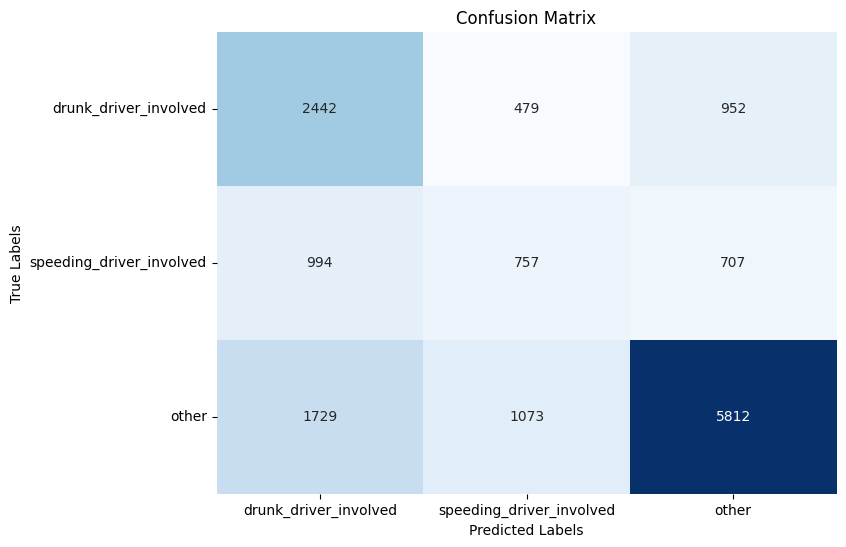

0.526882024305949


In [19]:
#Measure Output of MultiNomial Model
cat_lbl = ['drunk_driver_involved', 'speeding_driver_involved','other']
cm = confusion_matrix(y_test, predict, labels = cat_lbl )

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=cat_lbl,  yticklabels=cat_lbl)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print(f1_score(y_test, predict, average='macro', labels=cat_lbl))